In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import nltk
import sklearn
from transformers import pipeline
import shap

In [10]:
meta_cols = ['movie_id', 'title', 'year', 'rating', 'no. votes', 'genres']
meta = pd.read_table(
    './datasets/movie-dialog-corpus/movie_titles_metadata.tsv', sep='\t', header=None, names=meta_cols, index_col='movie_id')

line_cols = ['line_id', 'character_id', 'movie_id', 'character_name', 'text']
lines = pd.read_table('./datasets/movie-dialog-corpus/movie_lines.tsv', sep='\t',
                      header=None, names=line_cols, index_col='line_id', on_bad_lines='warn')

conv_cols = ['first_char', 'second_char', 'movie_id', 'line_ids']
convos = pd.read_table(
    './datasets/movie-dialog-corpus/movie_conversations.tsv', sep='\t', header=None, names=conv_cols, on_bad_lines='warn')


Skipping line 91031: expected 5 fields, saw 6
Skipping line 91081: expected 5 fields, saw 6
Skipping line 91082: expected 5 fields, saw 6
Skipping line 91157: expected 5 fields, saw 6
Skipping line 125360: expected 5 fields, saw 6
Skipping line 125472: expected 5 fields, saw 7
Skipping line 125492: expected 5 fields, saw 6
Skipping line 125536: expected 5 fields, saw 6

Skipping line 135069: expected 5 fields, saw 7
Skipping line 135833: expected 5 fields, saw 6
Skipping line 156053: expected 5 fields, saw 8
Skipping line 168095: expected 5 fields, saw 11
Skipping line 168096: expected 5 fields, saw 11
Skipping line 168148: expected 5 fields, saw 9
Skipping line 168182: expected 5 fields, saw 11
Skipping line 168201: expected 5 fields, saw 8
Skipping line 183605: expected 5 fields, saw 6
Skipping line 198531: expected 5 fields, saw 6
Skipping line 204507: expected 5 fields, saw 6
Skipping line 204637: expected 5 fields, saw 6
Skipping line 204671: expected 5 fields, saw 6
Skipping line

In [99]:
meta.head(20)

(617, 5)

In [5]:
classifier = pipeline("text-classification",
                      model="j-hartmann/emotion-english-distilroberta-base", top_k=None)
# classifier = pipeline("text-classification",
#                       model="bhadresh-savani/distilbert-base-uncased-emotion", top_k=None)

In [21]:
extractor = pipeline("feature-extraction",
                      model="j-hartmann/emotion-english-distilroberta-base", top_k=None)

Some weights of the model checkpoint at j-hartmann/emotion-english-distilroberta-base were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for p

In [12]:
import re

def str_to_list(str: str):
    return str.strip('\'[]').split("\' \'")

max_length = extractor.tokenizer.max_len_single_sentence

def get_line_groups(lines: list[str]):
    curr_group = None
    for line in lines:
        if not curr_group:
            curr_group = line
        elif len(curr_group) + len(line) > max_length:
            yield curr_group
        else:
            curr_group = ' '.join([curr_group, line])

def get_lines_text(row):
    try:
        line_texts = [lines.loc[id].text[:max_length] for id in str_to_list(row['line_ids'])]
        if sum([len(s) for s in line_texts]) <= max_length:
            return [' '.join(line_texts)]
        return get_line_groups(line_texts)
    except:
        return None
    
def preprocess_text(text):
    return re.sub('', ', ', re.sub('<.+>', ' ', text))

def get_dialog_texts():
    for i in tqdm(range(len(convos))):
        convo = convos.iloc[i]
        texts = get_lines_text(convo)
        if not texts:
            continue
        for text in texts:
            yield {
                'first_char': convo.first_char,
                'second_char': convo.second_char,
                'movie_id': convo.movie_id,
                'text': text
            }

NameError: name 'extractor' is not defined

In [26]:
dialog_texts = pd.DataFrame(get_dialog_texts())

  0%|          | 0/83097 [00:00<?, ?it/s]

In [260]:
min_dialog_count = 50
dialog_counts = dialog_texts.groupby('movie_id').count()['text']
dialog_texts = dialog_texts[(dialog_counts.loc[dialog_texts['movie_id']] >= min_dialog_count).values]

In [261]:
dialog_texts.to_pickle('./data/dialog_texts')

In [3]:
dialog_texts = pd.read_pickle('./data/dialog_texts')

In [3]:
dialog_texts.head()

,first_char,second_char,movie_id,text
0,u0,u2,m0,Can we make this quick? Roxanne Korrine and A...
1,u0,u2,m0,You're asking me out. That's so cute. What's ...
2,u0,u2,m0,No no it's my fault -- we didn't have a proper...
3,u0,u2,m0,Why? Unsolved mystery. She used to be really ...
4,u0,u2,m0,Gosh if only we could find Kat a boyfriend... ...


In [29]:
def movie_texts(movie_id) -> pd.Series:
    return dialog_texts[dialog_texts['movie_id'] == movie_id]['text']

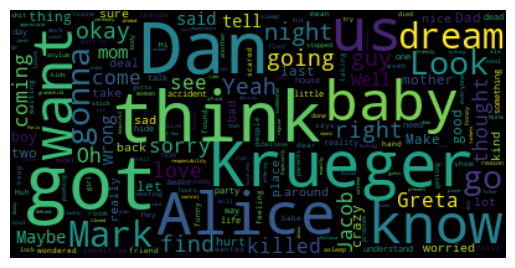

In [32]:
from wordcloud import WordCloud

wordcloud = WordCloud(max_font_size=60).generate(' '.join(movie_texts('m8'))) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [26]:
from lexical_diversity import lex_div as ld

def lexical_richness(text):
    words = nltk.tokenize.word_tokenize(text)
    return len(set(words)) / len(words)

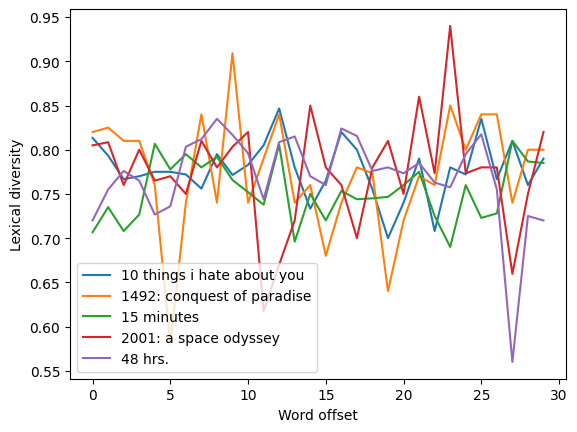

In [38]:

for mid, s in meta.head(5).iterrows():
    texts = movie_texts(mid).to_list()
    data = [ld.msttr(nltk.tokenize.word_tokenize(' '.join(ts))) for ts in np.array_split(texts, 30)]
    plt.plot(data, label=s['title'])
plt.legend()
plt.xlabel('Word offset') 
plt.ylabel('Lexical diversity') 
plt.show()

In [35]:
def get_text_features(text):
    features = extractor(text)
    return np.mean(features[0], axis=0)

In [15]:
m0_feats = pd.DataFrame(movie_texts('m0').map(get_text_features).to_list())

In [19]:
m0_feats = pd.DataFrame(m0_feats.text.to_list())

In [53]:
from sklearn.preprocessing import StandardScaler 
m0_feats_norm = StandardScaler().fit_transform(m0_feats)

In [77]:
from sklearn.manifold import MDS

mds_model = MDS(n_components=12, random_state=1)
out = mds_model.fit_transform(m0_feats_norm)

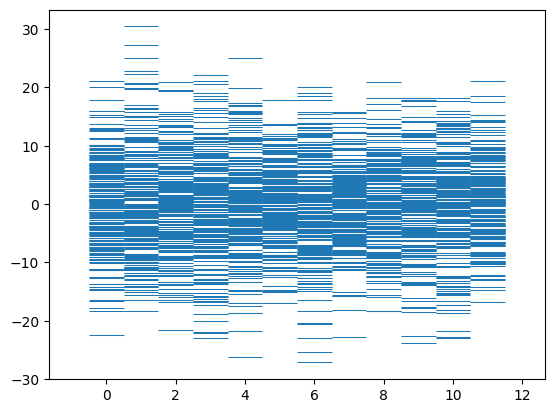

In [78]:

# plt.scatter(out[:, 0], out[:, 1], c=np.arange(0, len(m0_feats_norm)), cmap=plt.cm.Spectral) 
# plt.axis('equal')

fig, ax = plt.subplots()

ax.eventplot(out.T, orientation="vertical",  linewidth=0.75)

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

In [7]:
explainer = shap.Explainer(classifier) 

In [8]:
sentence = "Where'd you get this?!!"
classifier(sentence)

[[{'label': 'sadness', 'score': 0.6108067035675049},
  {'label': 'anger', 'score': 0.11496672034263611},
  {'label': 'fear', 'score': 0.09794864803552628},
  {'label': 'neutral', 'score': 0.0836629644036293},
  {'label': 'disgust', 'score': 0.04899681732058525},
  {'label': 'surprise', 'score': 0.03146027401089668},
  {'label': 'joy', 'score': 0.012157830409705639}]]

In [9]:
shap_values = explainer([sentence])

In [10]:
shap.plots.text(shap_values[0, :, "sadness"])

In [33]:
from sklearn.preprocessing import StandardScaler 
features_norm = StandardScaler().fit_transform(features[0]) 

In [37]:
from sklearn.decomposition import PCA 
pca = PCA(n_components = 2) 
principalComponents = pca.fit_transform(features_norm) 
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC 1', 'PC 2'])

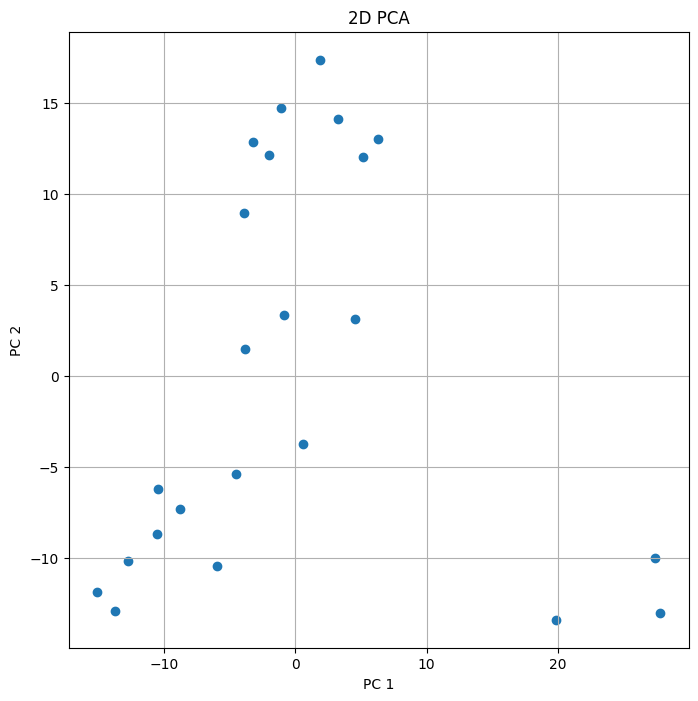

In [38]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('2D PCA')
ax.scatter(principalDf.loc[:, 'PC 1'],
           principalDf.loc[:, 'PC 2'])
ax.grid()


In [36]:
def get_emotion_feats(classifier_res: list[list[dict]]):
    return {x['label']: x['score'] for x in classifier_res[0]}


def get_dialog_emotions(df):
    for i in range(df.shape[0]):
        dialog = df.iloc[i]
        feats = get_emotion_feats(classifier(dialog.text))
        feats['movie_id'] = dialog.movie_id
        feats['text'] = dialog.text
        yield feats


In [37]:
def get_movie_emots(movie_id):
    return pd.DataFrame(get_dialog_emotions(dialog_texts[dialog_texts['movie_id'] == movie_id]))

In [38]:
movie_emots = pd.DataFrame(columns=[])

for i in tqdm(range(100)):
    movie = meta.iloc[i]
    movie_id = meta.index[i]
    emots = get_movie_emots(movie_id)
    movie_emots = pd.concat([movie_emots, emots])
    movie_emots.to_pickle('data/movie_emots_1')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/242 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/432 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

In [4]:
movie_emots = pd.read_pickle('data/movie_emots_1')

In [5]:
movie_avg_emots = movie_emots.drop(['text'], axis=1).groupby('movie_id').agg(
        np.average)
normalized = (movie_avg_emots-movie_avg_emots.mean())/movie_avg_emots.std()

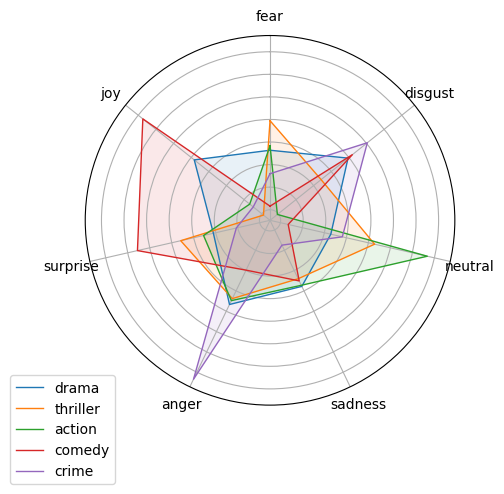

In [13]:
from math import pi

normalized['genres'] = meta.loc[normalized.index]['genres'].apply(
    lambda x: str_to_list(x))
exploded = normalized.explode('genres')
genre_avgs = exploded.groupby('genres').agg(np.average)
genre_stds = exploded.groupby('genres').agg(np.std)
genre_counts = exploded.groupby('genres').size()

def show_spider(data: pd.DataFrame, label_col: str = None):
    categories = (data.drop(label_col, axis=1) if label_col else data).columns.to_list()
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.axes.get_yaxis().set_ticklabels([])
    for id, v in data.iterrows():
        values = (v.drop(label_col) if label_col else v).values.tolist()
        values += values[:1]
        label = str(v[label_col]) if label_col else id
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)
    if len(data) > 1:
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

show_spider(genre_avgs.loc[genre_counts.nlargest().index])

In [14]:
genre_stds.loc[genre_counts.nlargest().index]

,fear,disgust,neutral,sadness,anger,surprise,joy
genres,,,,,,,
drama,0.972274,1.017840,0.953342,0.985246,1.012804,1.050190,1.233006
thriller,0.999933,0.864728,0.981705,0.960191,0.942370,0.933438,0.539665
action,0.803483,0.777785,0.930519,1.003296,0.929754,0.891854,0.573998
comedy,0.869061,1.041389,0.916056,0.868208,0.975953,0.894821,0.770822
crime,0.913322,0.989487,0.897080,0.950462,1.019330,0.870998,0.600216


In [68]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
X = np.array(normalized.iloc[:, 0:7])
top_genres = genre_counts.nlargest(10).index
print('top genres: ', top_genres.to_list())

genres = [[g for g in x if g in top_genres] for x in normalized['genres']]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(genres)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0)
X_test_df = pd.DataFrame(X_test, columns=movie_emots.columns[:7])


top genres:  ['drama', 'thriller', 'action', 'comedy', 'crime', 'romance', 'sci-fi', 'adventure', 'mystery', 'horror']


In [17]:
from sklearn.ensemble import RandomForestClassifier 
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train,y_train)

RandomForestClassifier()

In [19]:
from sklearn.neighbors import KNeighborsClassifier
kn_model = KNeighborsClassifier() 
kn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [18]:
from sklearn.model_selection import cross_val_score

# print(cross_val_score(KNeighborsClassifier(), X, y))
print(cross_val_score(RandomForestClassifier(n_estimators=200), X, y, scoring='recall_macro'))

[0.20823081 0.19256052 0.22844864 0.19163509 0.19577749]


In [66]:
from sklearn.metrics import *
from math import ceil, floor


y_predict_kn = kn_model.predict(X_test)
y_predict_rf = rf_clf.predict(X_test)

print('KNearest:')
print('Recall: {0}'.format(precision_score(y_true=y_test, y_pred=y_predict_kn, average='samples', zero_division=0))) 
print('Precision: {0}'.format(recall_score(y_true=y_test, y_pred=y_predict_kn, average='samples', zero_division=0)))
print('F1 Measure: {0}'.format(f1_score(y_true=y_test, y_pred=y_predict_kn, average='samples', zero_division=0)))
print('\nRandomForest:')
print('Recall: {0}'.format(precision_score(y_true=y_test, y_pred=y_predict_rf, average='samples', zero_division=0))) 
print('Precision: {0}'.format(recall_score(y_true=y_test, y_pred=y_predict_rf, average='samples', zero_division=0)))
print('F1 Measure: {0}'.format(f1_score(y_true=y_test, y_pred=y_predict_rf, average='samples', zero_division=0)))

KNearest:
Recall: 0.3817204301075269
Precision: 0.29489247311827954
F1 Measure: 0.3153609831029186

RandomForest:
Recall: 0.4650537634408602
Precision: 0.31962365591397845
F1 Measure: 0.3576036866359448


In [31]:
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer(X_train)

In [54]:
choosen_instance = X_test_df.iloc[0]
shap_values = explainer.shap_values(choosen_instance)
# print(shap_values)
# print(explainer.expected_value)
shap.initjs()
genre_i = np.where(mlb.classes_ == 'romance')[0][0]
shap.force_plot(explainer.expected_value[genre_i], shap_values[genre_i], choosen_instance)

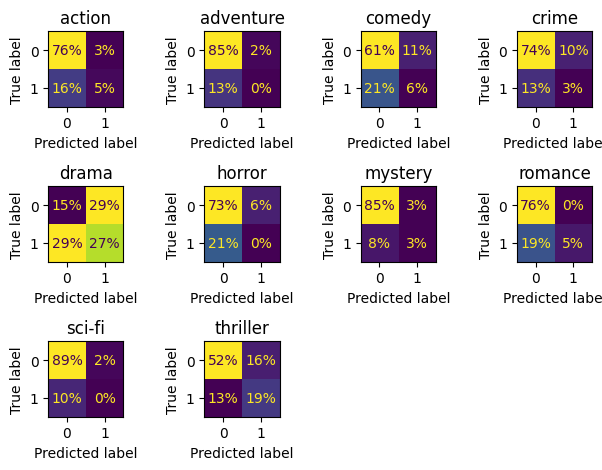

In [64]:
cols = 4
rows = ceil(y_test.shape[1] / cols)
# fig, axs = plt.subplots(rows, cols, sharey=True, sharex=True, figsize=(3*cols, 4*rows))
plt.figure()
i = 0
for cm in multilabel_confusion_matrix(y_true=y_test, y_pred=y_predict):
    genre = mlb.classes_[i]
    
    ax = plt.subplot(rows, cols, i + 1)
    plt.title(genre)
    s = cm.sum()
    cm_percent = np.array([[x / s for x in r] for r in cm])
    ConfusionMatrixDisplay(cm_percent).plot(ax=ax, colorbar=False, values_format=".0%")
    i += 1

plt.tight_layout()


In [163]:
y_test.shape[1]

5

In [129]:
mlb.inverse_transform(kn_model.predict(X_test[:2]))

[('comedy', 'romance'), ('drama', 'thriller')]

In [130]:
mlb.inverse_transform(y_test[:2])

[('comedy', 'romance'), ('drama',)]

In [97]:
[[g for g in x if genre_counts[g] > 19] for x in test_set['genres']]

[['comedy', 'drama', 'romance'],
 ['drama'],
 [],
 ['comedy', 'drama'],
 ['drama', 'romance'],
 ['drama', 'sci-fi', 'thriller'],
 ['sci-fi'],
 ['action', 'adventure', 'sci-fi', 'thriller'],
 ['action', 'adventure', 'thriller', 'action', 'adventure'],
 ['action', 'adventure']]